# Model Creation and Evaluation

In this report we create three regression models to predict the error vectors (both magnitude and angle), compare them with a baseline model, and evaluate the model performance by visualizing the mean-absolute error and means-quared error for both magnitudes and angles of the error vectors.

In [1]:
# Load packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load custom modules
import plotting_tools as pt
from custom_functions import fetch_data, prepare_data, train_predict

In [2]:
# Set the style of display
plt.style.use("ggplot")
%matplotlib inline

### Features Selection and Data Preprocessing

In [34]:
# Fetch all the data taken from a given camera
camera = "mx"
image_num = "."
image_nums_train = ["2"]
image_nums_test = ["3"]
df = fetch_data(camera, image_num)

# Create the training and test datasets
X_train, y_train = prepare_data(df, camera, image_nums=image_nums_train)
X_test, y_test = prepare_data(df, camera, image_nums=image_nums_test)

# Create polynomial features
#pw_list = [2, 3]
#X_train = np.hstack((X_train, np.power(X_train,pw_list[0]), np.power(X_train,pw_list[1])))
#X_test = np.hstack((X_test, np.power(X_test,2), np.power(X_test,3)))

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 42 samples.
Testing set has 41 samples.


In [39]:
l = "2" 
regex_txt = "err_.*" + camera + l 
dfn = df.filter(regex=regex_txt)
#dfn.dropna(inplace=True)
cols = ["err_mag_" + camera + l, "err_ang_"+ camera + l, "err_azm_"+ camera + l]
df_tmp = dfn.loc[:, cols]


In [45]:
dfn.describe()

,err_mag_mx2,err_r_mx2,err_ang_mx2,err_azm_mx2
count,115.000000,115.000000,98.000000,115.000000
mean,2.156539,531.218733,101.438478,34.022748
std,0.625118,251.130435,27.460691,20.017454
min,0.386588,9.218313,15.155884,2.147886
25%,1.643794,356.533943,82.916111,17.108948
50%,2.153845,596.907934,105.832814,36.554175
75%,2.685418,740.612167,116.660812,48.260529
max,3.149516,1009.864620,170.359913,89.817326


In [4]:
df.head()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1,err_azm_mx1,err_azm_mx2,err_azm_mx3
0,NaN,NaN,84.859260,NaN,NaN,84.859260,NaN,NaN,84.859260,NaN,NaN,NaN
1,NaN,NaN,34.887684,NaN,NaN,34.887684,NaN,NaN,34.887684,NaN,NaN,NaN
2,NaN,NaN,94.018541,NaN,NaN,94.018541,NaN,NaN,94.018541,NaN,NaN,NaN
3,NaN,NaN,93.243282,NaN,NaN,93.243282,NaN,NaN,93.243282,NaN,NaN,NaN
4,NaN,NaN,93.064243,NaN,NaN,93.064243,NaN,NaN,93.064243,NaN,NaN,NaN


In [6]:
df.describe()

,err_mag_mx3,err_r_mx3,err_ang_mx3,err_mag_mx2,err_r_mx2,err_ang_mx2,err_mag_mx1,err_r_mx1,err_ang_mx1,err_azm_mx1,err_azm_mx2,err_azm_mx3
count,112.000000,112.000000,98.000000,115.000000,115.000000,98.000000,21.000000,21.000000,98.000000,21.000000,115.000000,112.000000
mean,1.708790,542.145293,101.438478,2.156539,531.218733,101.438478,0.929675,563.367564,101.438478,67.673014,34.022748,48.565439
std,0.727047,263.917057,27.460691,0.625118,251.130435,27.460691,0.611878,186.577424,27.460691,12.685091,20.017454,20.857236
min,0.111400,9.102225,15.155884,0.386588,9.218313,15.155884,0.082680,156.328580,15.155884,28.947091,2.147886,0.400010
25%,1.263753,348.696906,82.916111,1.643794,356.533943,82.916111,0.627360,532.972339,82.916111,64.308649,17.108948,35.790264
50%,1.744043,606.238980,105.832814,2.153845,596.907934,105.832814,0.823817,613.679713,105.832814,68.227018,36.554175,45.987238
75%,2.171537,745.952198,116.660812,2.685418,740.612167,116.660812,1.076075,658.501959,116.660812,75.999460,48.260529,62.109004
max,3.359036,1013.690734,170.359913,3.149516,1009.864620,170.359913,3.119703,816.381060,170.359913,81.793047,89.817326,89.429611


## Build Models

#### Build a baseline model

In [7]:
# Calculate MAE and MSE of the baseline model
baseline_prediction_MAE_train = np.mean(np.abs(y_train - np.mean(y_train, axis=0)), axis=0)
baseline_prediction_MAE_test = np.mean(np.abs(y_test - np.mean(y_test, axis=0)), axis=0)
baseline_prediction_MSE_train = np.square(np.abs(y_train - np.mean(y_train, axis=0))).mean(axis=0)
baseline_prediction_MSE_test = np.square(np.abs(y_test - np.mean(y_test, axis=0))).mean(axis=0)
baseline_error_dict = {"baseline_prediction_MAE_train":baseline_prediction_MAE_train,
                       "baseline_prediction_MAE_test":baseline_prediction_MAE_test,
                       "baseline_prediction_MSE_train":baseline_prediction_MSE_train,
                       "baseline_prediction_MSE_test":baseline_prediction_MSE_test}
baseline_error_mag_dict = {ky:baseline_error_dict[ky][0] for ky in baseline_error_dict.keys()}
baseline_error_ang_dict = {ky:baseline_error_dict[ky][1] for ky in baseline_error_dict.keys()}

In [8]:
baseline_error_dict

{'baseline_prediction_MAE_test': array([  0.56093514,  24.54021722]),
 'baseline_prediction_MAE_train': array([  0.49620736,  23.93937673]),
 'baseline_prediction_MSE_test': array([  4.53528997e-01,   9.93919547e+02]),
 'baseline_prediction_MSE_train': array([  3.14017641e-01,   8.86882975e+02])}

#### Build three regression models

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Initialize the three models
# build a linear regression
clf_LR = LinearRegression()

# build a GradientBoosting Regressor model
clf_GB = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=10, random_state=16)

# build a Random Forest model
clf_RF = RandomForestRegressor(n_estimators=10, random_state=16)

## Model Evaluation

#### Evaluate the above three model results in terms of mean-absolute error (MAE) and mean-squared error (MSE) of the error vector magnitude

MultiOutputRegressor trained on 12 samples.
MultiOutputRegressor trained on 21 samples.
MultiOutputRegressor trained on 42 samples.
MultiOutputRegressor trained on 12 samples.
MultiOutputRegressor trained on 21 samples.
MultiOutputRegressor trained on 42 samples.
MultiOutputRegressor trained on 12 samples.
MultiOutputRegressor trained on 21 samples.
MultiOutputRegressor trained on 42 samples.


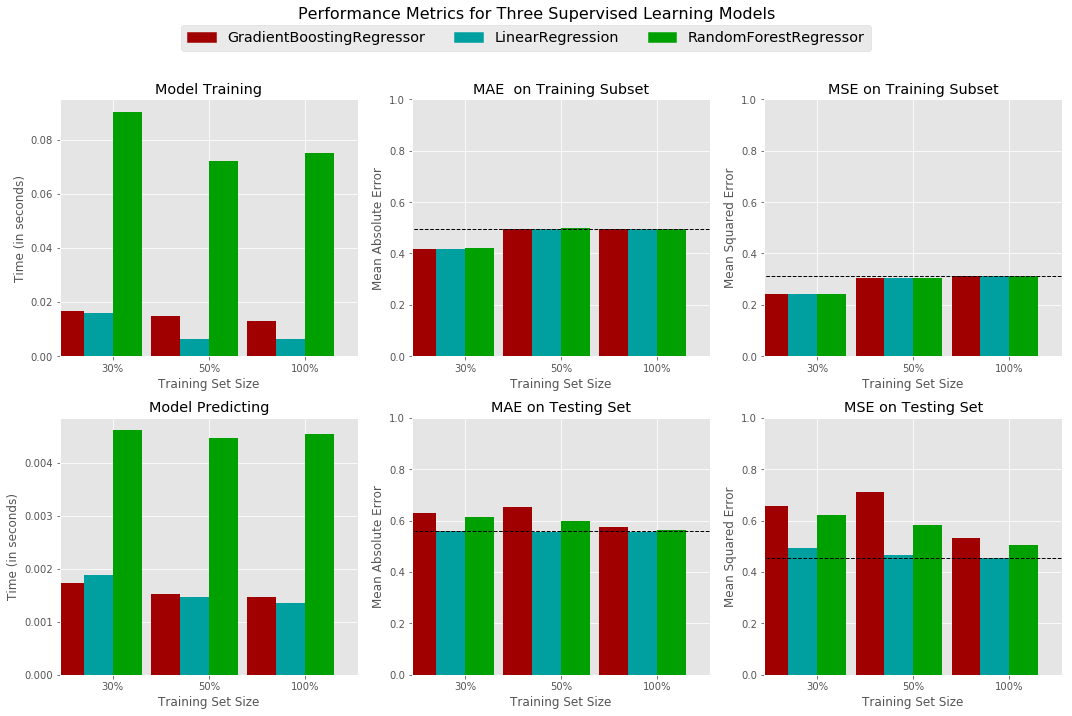

In [10]:
# calculate the number of samples for 1%, 10%, and 100% of the training data
samples_30 = int(0.3 * len(X_train))
samples_50 = int(0.5 * len(X_train))
samples_100 = len(X_train)

# collect results on the learners
results = {}
for clf in [clf_LR, clf_GB, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    clf = MultiOutputRegressor(clf)
    for i, samples in enumerate([samples_30, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three models
pt.evaluate(results, baseline_error_mag_dict, params="magnitude")

#### Evaluate the above three model results in terms of absolute error (AE) of the error vector magnitude

(0, 3.0)

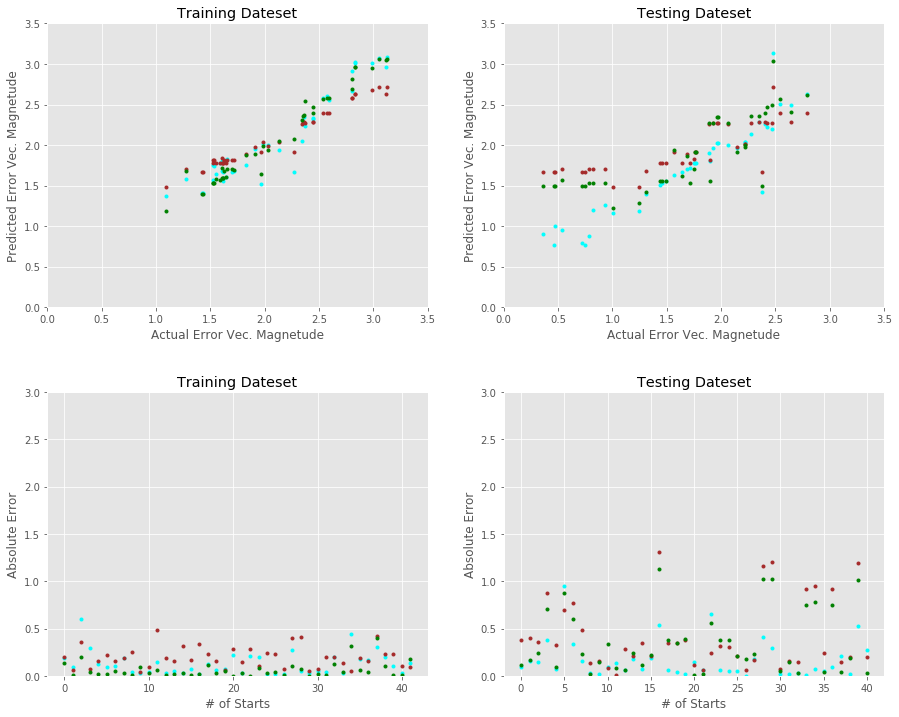

In [11]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,0], yhat_train[:,0], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,0].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 0], yhat_test[:, 0], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Magnetude")
    axes[0,1].set_ylabel("Predicted Error Vec. Magnetude")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 0] - y_train[:, 0])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Starts")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 0] - y_test[:, 0])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Starts")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 3.5])
axes[0,1].set_xlim([0, 3.5])
axes[0,0].set_ylim([0, 3.5])
axes[0,1].set_ylim([0, 3.5])
axes[1,0].set_ylim([0, 3.0])
axes[1,1].set_ylim([0, 3.0])

#### Evaluate the above three model results in terms of absolute error (AE) of the error vector angle

(0, 90)

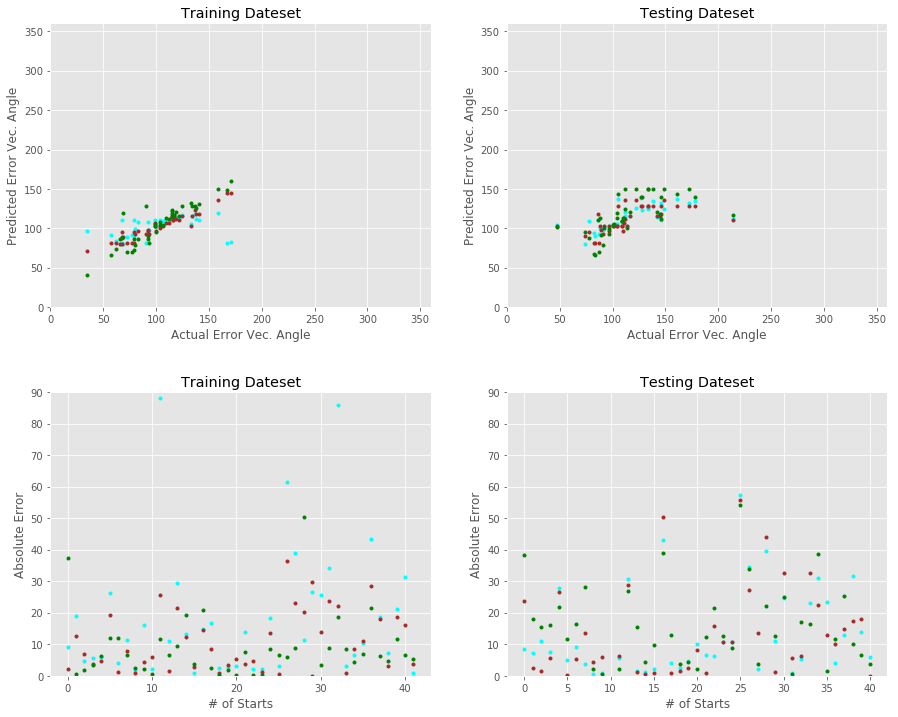

In [12]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
plt.subplots_adjust(hspace=0.3)
colors = ['cyan', 'brown', 'green']
for i, clf in enumerate([clf_LR, clf_GB, clf_RF]):
    # Plot the predicted error magnitude vs "true" error magnitude for training data
    clf_name = clf.__class__.__name__
    yhat_train = results[clf_name][2]["yhat_train"]
    axes[0,0].plot(y_train[:,1], yhat_train[:,1], '.', color=colors[i])
    axes[0,0].set_xlabel("Actual Error Vec. Angle")
    axes[0,0].set_ylabel("Predicted Error Vec. Angle")
    axes[0,0].set_title("Training Dateset")
    
    # Plot the predicted error magnitude vs "true" error magnitude for testing data
    yhat_test = results[clf_name][2]["yhat_test"]
    axes[0,1].plot(y_test[:, 1], yhat_test[:, 1], '.', color=colors[i])
    axes[0,1].set_xlabel("Actual Error Vec. Angle")
    axes[0,1].set_ylabel("Predicted Error Vec. Angle")
    axes[0,1].set_title("Testing Dateset")
    
    # Plot the MAE for training data
    AE_train = np.abs(yhat_train[:, 1] - y_train[:, 1])
    axes[1,0].plot(AE_train, '.', color=colors[i])
    axes[1,0].set_ylabel("Absolute Error")
    axes[1,0].set_xlabel("# of Starts")
    axes[1,0].set_title("Training Dateset")
    
    # Plot the MAE for testing data
    AE_test = np.abs(yhat_test[:, 1] - y_test[:, 1])
    axes[1,1].plot(AE_test, '.', color=colors[i])
    axes[1,1].set_ylabel("Absolute Error")
    axes[1,1].set_xlabel("# of Starts")
    axes[1,1].set_title("Testing Dateset")
    
axes[0,0].set_xlim([0, 360])
axes[0,1].set_xlim([0, 360])
axes[0,0].set_ylim([0, 360])
axes[0,1].set_ylim([0, 360])
axes[1,0].set_ylim([0, 90])
axes[1,1].set_ylim([0, 90])